Stepwise explore the error propagation

In [83]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

from FEANet.mesh import MeshCircInterface
from FEANet.geo import Geometry
from FEANet.jacobi import JacobiBlock
from FEANet.model import KNet, FNet
from Utils import plot

In [84]:
class SingleGrid():
    '''
    Perform weighted Jacobi iteration relaxation for a single grid.
    Note: the n should be the number of intervals, e.g., 
          there are (n+1)*(n+1) grid points in total if the size is n
          f has already been convoluted, i.e., f = fnet(ff) if ff is the sourcing term of PDE
    '''
    def __init__(self, size, n):
        self.size = size # actual size of the plate
        self.n = n 
        self.omega = 2/3.
        self.property = [1, 20] # homogeneous problem
        self.plate = Geometry(n+1)
        self.grid = MeshCircInterface(size, prop=self.property, nnode_edge=n+1)
        self.v = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
        self.f = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
        self.InstantiateFEANet()
        self.jac = JacobiBlock(self.Knet, self.grid, self.omega, self.plate.geometry_idx, self.plate.boundary_value)
        
    def InstantiateFEANet(self):
        self.Knet = KNet(self.grid) # Initialize the stiffness network, given mesh
        self.fnet = FNet(self.size/self.n) # Initialize the forcing term network, given mesh size
        for param in self.Knet.parameters():
            param.requires_grad = False
        for param in self.fnet.parameters():
            param.requires_grad = False

    def Relax(self, v, f, num_sweeps_down):
        '''
        Perform a fixed number of weighted Jacobi iteration
        '''
        v = self.jac.jacobi_convolution(v, f, n_iter=num_sweeps_down)
        return v


In [85]:
class Multigrid():
    '''Define the multigrid problem for 2D, n is the finest grid size'''
    def __init__(self, n = 64, final_level = None):
        self.size = 2
        self.n = n # total number of grids for finest grid
        if(final_level is None):
            self.L = int(np.log2(n)) # number of levels for V-cycle multigrid
        else:
            self.L = final_level
        self.solution = []
        
        self.n_arr = self.SizeArray() # array to store grid size for each level
        self.grids = self.GridDict() # dictionary of structure grids
        
        ff = torch.ones(1, 1, n+1, n+1)
        self.grids[0].f = self.grids[0].fnet(ff.reshape(1,1,n+1,n+1)) # assign the finest right hand side with the original rhs


    def SizeArray(self):
        n_arr = []
        for i in range(self.L):
            n_arr.append(int(self.n/(2.**i)))
        n_arr = np.array(n_arr)
        return n_arr

    def GridDict(self):
        grids = {}
        for i in range(self.L):
            grids[i] = SingleGrid(self.size, self.n_arr[i])
        return grids

    def Restrict(self, f):
        '''
        Perform full weighting operation to down sample to next level
        '''
        f_res = f[:, :, 1:-1, 1:-1]
        restriction_kernel = 4 * torch.asarray([[1, 2, 1],
                                            [2, 4, 2],
                                            [1, 2, 1]], dtype=torch.float32) / 16.0

        f_res = F.conv2d(f_res, restriction_kernel.view(1, 1, 3, 3), stride=2)
        return F.pad(f_res,(1,1,1,1),"constant",0) # pad with zeros

    def Interpolate(self, v):
        '''
        Perform linear interpolation and upsample to previous level ==> Return size: (2*N - 1), Ex. 17 -> 33
        '''
        _, _, image_size, _ = v.shape
        new_size = 2 * image_size - 1
        v = F.interpolate(v, size=new_size, mode='bilinear', align_corners=True)
        level = np.where(self.n_arr == new_size-1)[0][0]
        return self.grids[level].jac.reset_boundary(v)

    def Error(self,v):
        '''
        Compute the error between current approximation and exact solution
        v should be a 1D vector
        '''
        return torch.linalg.norm(v.reshape(-1)-self.u_exact.reshape(-1), ord=torch.inf)
    
    def rec_V_cycle(self, l, v, f):
        '''
        Perform recursive V-cycle
        Input: l, current level (starts from 0)
        Output: residual
        '''
        n_sample = 1
        self.grids[l].v = v
        self.grids[l].f = f
        self.grids[0].v = self.grids[0].Relax(self.grids[0].v, self.grids[0].f, n_sample)
        if(l < self.L-1):
            residual = self.grids[l].f-self.grids[l].Knet(self.grids[l].v)
            self.grids[l+1].f = self.Restrict(residual)
            self.grids[l+1].v *= 0.
            self.rec_V_cycle(l+1, self.grids[l+1].v, self.grids[l+1].f)
            self.grids[l].v += self.Interpolate(self.grids[l+1].v)
            self.grids[l+1].v *= 0.
        
        self.grids[l].v = self.grids[l].Relax(self.grids[l].v, self.grids[l].f, n_sample)


In [86]:
EPS = 5e-5
n = 2**6
prob_jacobi = Multigrid(n)

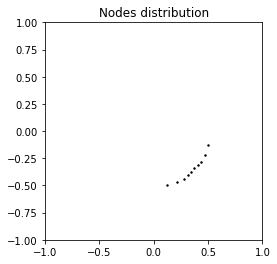

In [87]:
plot.plot_pattern(prob_jacobi.grids[0].grid, key=2)

In [88]:
def compute_q(res_arr, m, m0):
    return np.power(res_arr[m]/res_arr[m0], 1.0/(m-m0+1))

1.848229196483925 84.76860809326172
12.900631717422398 19.28577995300293
0.9412411454729199 4.690768241882324
0.886449802727623 1.217702031135559
0.1695380586605536 0.31946611404418945
0.09196030211091408 0.09897864609956741
0.028818753913844957 0.028640594333410263
0.011681358275497485 0.013580460101366043
0.007778071023408358 0.005534196738153696
0.0036049809645281304 0.0032428069971501827
0.0024866774724630098 0.0016168231377378106
0.0013234394004716953 0.0009159205947071314
0.0008073989355216629 0.0004833694256376475
0.00044114262969072437 0.00026707854704000056
0.00025268444957827455 0.0001438054459867999
0.00014033995765642764 7.871487468946725e-05
7.635691872865022e-05 4.354358679847792e-05
Solution converges after 17 V-cycle iterations with relative error of 7.635691872865022e-05


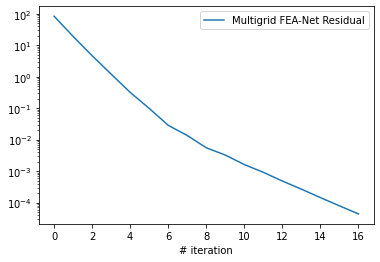

In [89]:
# Multigrid implementation
prob_mg = Multigrid(n)

n_recV_cycle = 0
prob_mg.grids[0].v = torch.randn((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
e_arr_recV_cycle = [1]
res_arr_recV_cycle = [1]
res = 1
while (abs(res)>EPS):
    u_prev = prob_mg.grids[0].v 
    prob_mg.rec_V_cycle(0,prob_mg.grids[0].v,prob_mg.grids[0].f)
    e_recV_cycle = torch.sqrt(torch.sum((prob_mg.grids[0].v - u_prev) ** 2)).item() / torch.sqrt(torch.sum((prob_mg.grids[0].v) ** 2)).item()
    e_arr_recV_cycle.append(e_recV_cycle)
    residual = prob_mg.grids[0].f-prob_mg.grids[0].Knet(prob_mg.grids[0].v)
    res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
    res_arr_recV_cycle.append(res)
    print(e_recV_cycle, res)
    n_recV_cycle += 1

print("Solution converges after", n_recV_cycle, "V-cycle iterations with relative error of", e_recV_cycle)

plt.plot(res_arr_recV_cycle[1:], label='Multigrid FEA-Net Residual')
plt.yscale('log')
plt.xlabel('# iteration')
plt.legend()

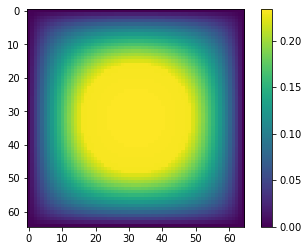

In [90]:
plot.plot_field(prob_mg.grids[0].v)

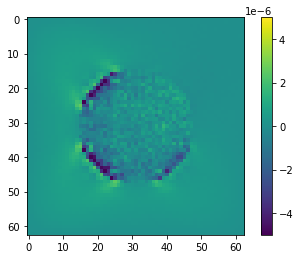

(array([1.000e+00, 3.000e+00, 0.000e+00, 1.000e+00, 5.000e+00, 6.000e+00,
        4.000e+00, 8.000e+00, 1.200e+01, 1.500e+01, 1.600e+01, 4.300e+01,
        6.100e+01, 1.490e+02, 1.194e+03, 1.879e+03, 4.610e+02, 8.400e+01,
        1.500e+01, 1.200e+01]),
 array([-7.3175179e-06, -6.8238733e-06, -6.3302286e-06, -5.8365840e-06,
        -5.3429394e-06, -4.8492948e-06, -4.3556502e-06, -3.8620055e-06,
        -3.3683609e-06, -2.8747163e-06, -2.3810717e-06, -1.8874271e-06,
        -1.3937824e-06, -9.0013782e-07, -4.0649320e-07,  8.7151420e-08,
         5.8079604e-07,  1.0744407e-06,  1.5680853e-06,  2.0617299e-06,
         2.5553745e-06], dtype=float32),
 <BarContainer object of 20 artists>)

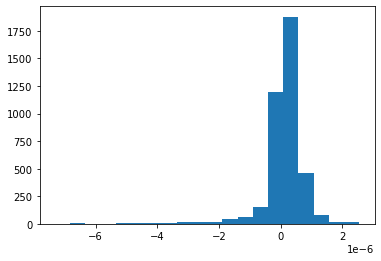

In [91]:
# Residual plots (except for boundaries)
residual_mg = prob_mg.grids[0].f-prob_mg.grids[0].Knet(prob_mg.grids[0].v)
plot.plot_field(residual_mg[:, :, 1:-1, 1:-1],limit=[-EPS/10,EPS/10])
res_mg_flat = torch.flatten(residual_mg[:, :, 1:-1, 1:-1]).detach().numpy()
plt.hist(res_mg_flat, bins=20)

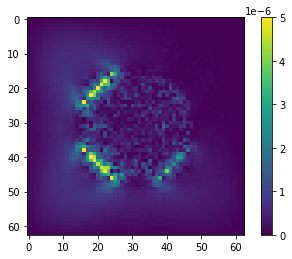

(array([2.437e+03, 1.046e+03, 2.390e+02, 1.050e+02, 4.600e+01, 2.800e+01,
        1.700e+01, 1.300e+01, 9.000e+00, 8.000e+00, 4.000e+00, 1.000e+00,
        6.000e+00, 5.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 3.000e+00,
        0.000e+00, 1.000e+00]),
 array([1.1641532e-10, 3.6598649e-07, 7.3185657e-07, 1.0977267e-06,
        1.4635967e-06, 1.8294668e-06, 2.1953369e-06, 2.5612069e-06,
        2.9270770e-06, 3.2929470e-06, 3.6588171e-06, 4.0246873e-06,
        4.3905575e-06, 4.7564272e-06, 5.1222974e-06, 5.4881675e-06,
        5.8540377e-06, 6.2199078e-06, 6.5857776e-06, 6.9516477e-06,
        7.3175179e-06], dtype=float32),
 <BarContainer object of 20 artists>)

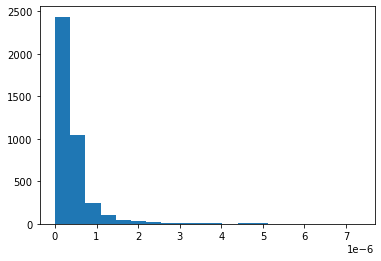

In [92]:
# Residual plots (except for boundaries)
residual_mg = prob_mg.grids[0].f-prob_mg.grids[0].Knet(prob_mg.grids[0].v)
plot.plot_field(torch.abs(residual_mg[:, :, 1:-1, 1:-1]),limit=[0,EPS/10])
res_mg_flat = torch.flatten(torch.abs(residual_mg[:, :, 1:-1, 1:-1])).detach().numpy()
plt.hist(res_mg_flat, bins=20)

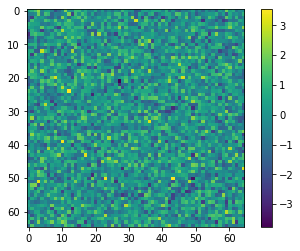

In [93]:
# stepwise interpolation study
step_mg = Multigrid(n)

step_mg.grids[0].v = torch.randn((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)

plot.plot_field(step_mg.grids[0].v) # initial solution

In [94]:
# perform one-step smooth
n_sample = 500
step_mg.grids[0].v = step_mg.grids[0].Relax(step_mg.grids[0].v, step_mg.grids[0].f, n_sample)

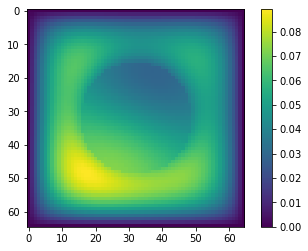

In [95]:
plot.plot_field(step_mg.grids[0].v) # calculated solution

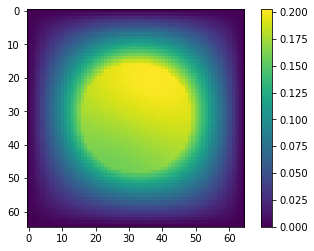

In [96]:
plot.plot_field(prob_mg.grids[0].v-step_mg.grids[0].v) # error

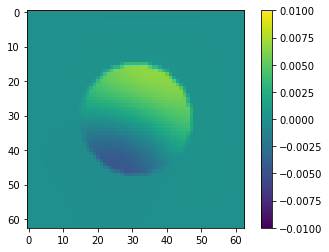

In [97]:
# calculate residual
res_step1 = step_mg.grids[0].f-step_mg.grids[0].Knet(step_mg.grids[0].v)
plot.plot_field(res_step1[:, :, 1:-1, 1:-1],limit=[-1e-2,1e-2])

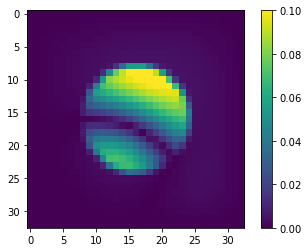

In [98]:
# restrict the residual to coarse grid
step_mg.grids[1].f = 4*step_mg.Restrict(res_step1)
plot.plot_field(torch.abs(step_mg.grids[1].f),limit=[0,1e-1])

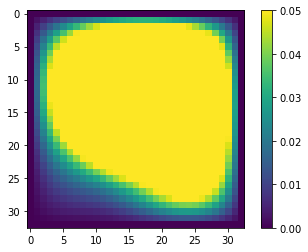

In [99]:
# calculate the coarse grid error
step_mg.grids[1].v = step_mg.grids[1].Relax(step_mg.grids[1].v, step_mg.grids[1].f, n_sample)
plot.plot_field(torch.abs(step_mg.grids[1].v),limit=[0,5e-2])

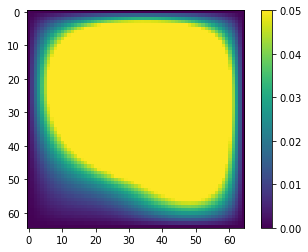

In [100]:
step1_inter = step_mg.Interpolate(step_mg.grids[1].v)
plot.plot_field(torch.abs(step1_inter),limit=[0,5e-2]) # interpolated error

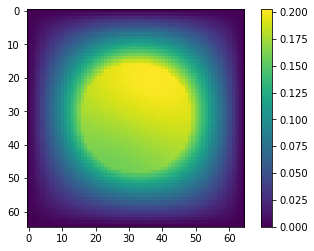

In [101]:
plot.plot_field(prob_mg.grids[0].v-step_mg.grids[0].v) # true - calculated

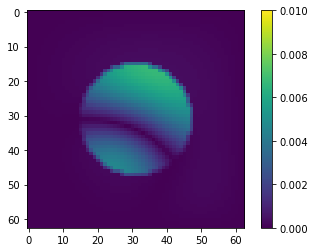

In [102]:
residual_step = step_mg.grids[0].f-step_mg.grids[0].Knet(step_mg.grids[0].v)
plot.plot_field(torch.abs(residual_step[:, :, 1:-1, 1:-1]),limit=[0,1e-2])